<a href="https://colab.research.google.com/github/saiful1604008/Thesis/blob/main/topomap.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import os
import numpy as np

In [ ]:
pip install wfdb

In [21]:
import wfdb 

dbs = wfdb.get_dbs()

records_list = wfdb.io.get_record_list('chbmit', records='all')
records_list[:5]

['chb01/chb01_01.edf',
 'chb01/chb01_02.edf',
 'chb01/chb01_03.edf',
 'chb01/chb01_04.edf',
 'chb01/chb01_05.edf']

In [ ]:
part_codes = sorted(list(set([record.split('/')[0] for record in records_list])))
part_codes

In [ ]:
import os
from urllib.request import urlretrieve

def get_content(part_code):
  url = "https://physionet.org/physiobank/database/chbmit/"+part_code+'/'+part_code+'-summary.txt'
  filename = "./chbmit.txt"

  urlretrieve(url,filename)

  # read the file into a list
  with open(filename, encoding='UTF-8') as f:
      # read all the document into a list of strings (each line a new string)
      content = f.readlines()
      os.remove(filename)

  return content

get_content(part_codes[0])

In [ ]:
pip install re

In [27]:
import pandas as pd    
import re

all_channels = []

for key in part_info_dict.keys():
    all_channels.extend(part_info_dict[key]['Channels'])
    
all_channels = pd.Series(all_channels)

channel_counts = all_channels.value_counts()
channel_counts

C4-P4      675
F8-T8      675
P3-O1      675
FP1-F7     675
F7-T7      675
          ... 
P4          13
T8          13
CP4         13
CZ          13
LOC-ROC     11
Length: 87, dtype: int64

In [28]:
threshold = len(part_info_dict.keys())
channel_keeps = list(channel_counts[channel_counts >= threshold].index)
channel_keeps

['C4-P4',
 'F8-T8',
 'P3-O1',
 'FP1-F7',
 'F7-T7',
 'FP2-F4',
 'P4-O2',
 'FZ-CZ',
 'C3-P3',
 'T8-P8',
 'F4-C4',
 'T7-P7',
 'P8-O2',
 'FP1-F3',
 'P7-O1',
 'F3-C3',
 'CZ-PZ',
 'FP2-F8']

In [29]:
EXAMPLE_FILE = records_list[17]
EXAMPLE_ID = EXAMPLE_FILE.split('/')[1].split('.')[0]
EXAMPLE_ID

'chb01_18'

In [ ]:
pip install pyedflib

In [34]:
def mne_object(data, freq, events = None):
  # create an mne info file with meta data about the EEG
  info = mne.create_info(ch_names=list(data.columns), 
                         sfreq=freq, 
                         ch_types=['eeg']*data.shape[-1])
  
  # data needs to be in volts rather than in microvolts
  data = data.apply(lambda x: x*1e-6)
  # transpose the data
  data_T = data.transpose()
  
  # create raw mne object
  raw = mne.io.RawArray(data_T, info)

  if events:
    start_times = np.array(events[::2])
    end_times = np.array(events[1::2])
    anno_length = end_times-start_times
    event_name = np.array(['Ictal']*len(anno_length))

    raw.set_annotations(mne.Annotations(start_times,
                                      anno_length,
                                      event_name))

  return raw

mne_data = mne_object(raw_data, freq, part_info_dict[EXAMPLE_ID]['Seizures Window'])




Creating RawArray with float64 data, n_channels=18, n_times=921600
    Range : 0 ... 921599 =      0.000 ...  3599.996 secs
Ready.


In [55]:
mne.channels.get_builtin_montages()

['EGI_256',
 'GSN-HydroCel-128',
 'GSN-HydroCel-129',
 'GSN-HydroCel-256',
 'GSN-HydroCel-257',
 'GSN-HydroCel-32',
 'GSN-HydroCel-64_1.0',
 'GSN-HydroCel-65_1.0',
 'biosemi128',
 'biosemi16',
 'biosemi160',
 'biosemi256',
 'biosemi32',
 'biosemi64',
 'easycap-M1',
 'easycap-M10',
 'mgh60',
 'mgh70',
 'standard_1005',
 'standard_1020',
 'standard_alphabetic',
 'standard_postfixed',
 'standard_prefixed',
 'standard_primed',
 'artinis-octamon',
 'artinis-brite23']

In [79]:
replace_dict = {}
drop_list = []
for channel_name in mne_data.info['ch_names']:
    name_change = re.findall('\w+',channel_name)[0].title()
 
    if name_change in list(replace_dict.values()):
        drop_list.append(channel_name)
    else:
      
        replace_dict[channel_name] = name_change

mne_data.drop_channels(drop_list)
mne_data.rename_channels(replace_dict)
mne_data.set_montage('standard_1020')

<RawArray | 16 x 921600 (3600.0 s), ~112.5 MB, data loaded>

In [69]:
import matplotlib.pyplot as plt

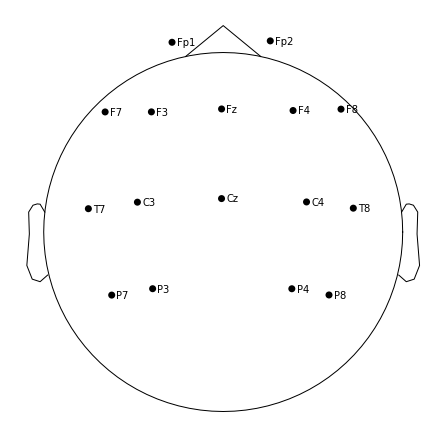

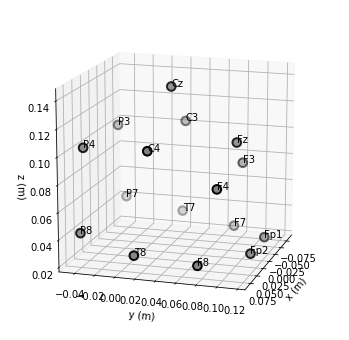

In [73]:
mne_data.plot_sensors(kind='topomap', show_names=True, to_sphere=True);
fig = mne_data.plot_sensors(kind='3d', show_names=True, show=False, ch_groups = 'position')
fig = fig.gca().view_init(azim=17, elev=15)
plt.show()

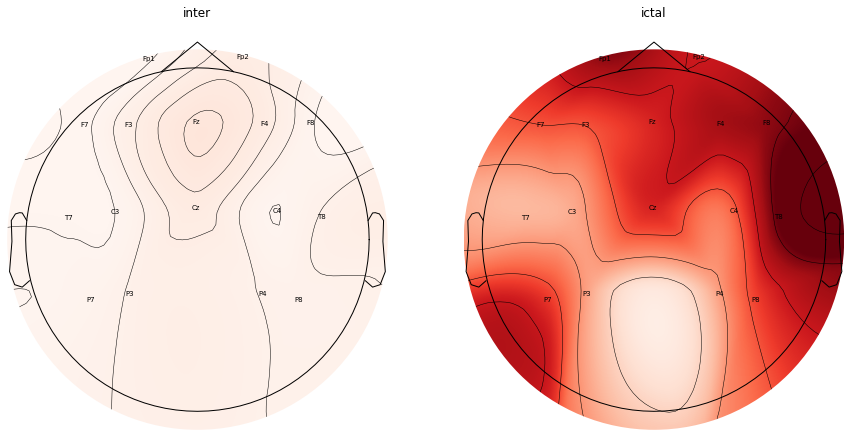

In [76]:
from scipy import signal
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15,15))

axs = axs.flatten()
for i, data_class in enumerate(topo_df.T):
    topo, cn = mne.viz.plot_topomap(topo_df.loc[data_class],
                                    mne_data.info,
                                    show=False,
                                    sensors=False,
                                    names=mne_data.info['ch_names'], 
                                    show_names=True,
                                    axes = axs[i],
                                    vmin = topo_df.values.min(),
                                    vmax = topo_df.values.max())
    axs[i].set_title(data_class)
    
fig.show()


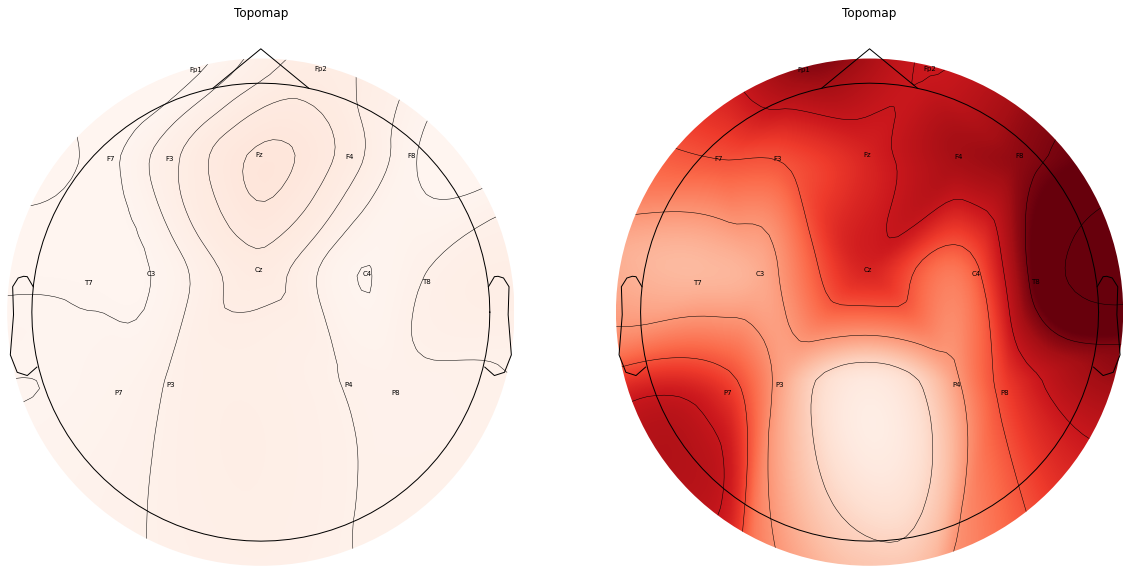

In [82]:
from scipy import signal
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(20,10))

axs = axs.flatten()
for i, data_class in enumerate(topo_df.T):
    topo, cn = mne.viz.plot_topomap(topo_df.loc[data_class],
                                    mne_data.info,
                                    show=False,
                                    sensors=False,
                                    names=mne_data.info['ch_names'], 
                                    show_names=True,
                                    axes = axs[i],
                                    vmin = topo_df.values.min(),
                                    vmax = topo_df.values.max())
    axs[i].set_title('Topomap')
    
fig.show()
